In [1]:
import pandas as pd
import numpy as np
import nltk
import json
import io
import dateutil
import re
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import itertools
import warnings

from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import stopwords
from wordcloud import WordCloud


warnings.filterwarnings("ignore")
sns.set()
plt.rcParams["font.serif"] = "cmr10"

# Graphics in retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina'

In [2]:
stop_words = set(
    stopwords.words('english') + list(punctuation) + ['AT_USER', 'URL'])

In [3]:
def get_tweets_from_json_file(mode):
    """
    :param mode: can be "kcca", "moh", "influencers", "moh_engagement" e.t.c depending on the data being analyzed
    """
    filename = "{}_analysis_tweets.json".format(mode)
    with io.open(filename, 'r', encoding='utf-8') as f:
        json_data = json.load(f)
        f.close()
    return json_data['tweets']

In [4]:
moh_engagement_tweets = get_tweets_from_json_file("moh")

In [5]:
print("Number of tweets: {}".format(len(moh_engagement_tweets)))

Number of tweets: 155


In [6]:
def get_tweet_words(tweet):
    """Clean up tweet"""
    
    tweet = tweet.lower()  # convert text to lower-case
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL',
                   tweet)  # remove URLs
    tweet = re.sub('@[^\s]+', 'AT_USER', tweet)  # remove usernames
    tweet = re.sub(r'#([\w]+)', '', tweet)  # remove the # in #hashtag
    tweet = word_tokenize(
        tweet)  # remove repeated characters (helloooooooo into hello)
    return [word for word in tweet if word not in stop_words and len(word) > 3]


def is_retweet(tweet):
    if "referenced_tweets" in tweet:
        ref_tweets = tweet["referenced_tweets"]
        for ref_t in ref_tweets:
            if ref_t['type'] == 'retweeted':
                return True
    return False

def filter_tweets(tweets):
    return [tweet for tweet in tweets if not (is_retweet(tweet) or tweet['username'].isnumeric())]


def process_tweet(tweet):
    """Process tweets from raw files"""
    username = tweet['username']
    user_id = tweet['user_id']
    tweet_id = tweet['id']
    created_time = dateutil.parser.parse(
        tweet['created_at']).replace(tzinfo=None)
    text = tweet['text']
    words = get_tweet_words(text)
    retweet_count = tweet['public_metrics']['retweet_count']
    reply_count = tweet['public_metrics']['reply_count']
    quote_count = tweet['public_metrics']['quote_count']
    like_count = tweet['public_metrics']['like_count']
    engagement = retweet_count + reply_count + quote_count + like_count
#     followers_count = tweet['user']['followers_count']
    return {
        'username': username,
        'user_id': user_id,
        'tweet_id': tweet_id,
        'created_time': created_time,
        'text': text,
        'words': words,
        'retweet_count': retweet_count,
        'reply_count': reply_count,
        'quote_count': quote_count,
        'like_count': like_count,
        'engagement': engagement
    }


def create_pd_frame(tweets):
    filtered_tweets = filter_tweets(tweets)
    df = pd.DataFrame([process_tweet(tweet) for tweet in filtered_tweets])
    df.set_index('created_time', inplace=True)
    return df

In [7]:
df = create_pd_frame(moh_engagement_tweets)

In [8]:
df.shape

(107, 10)

In [10]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 107 entries, 2020-09-24 05:08:06 to 2020-10-12 12:14:24
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   username       107 non-null    object
 1   user_id        107 non-null    object
 2   tweet_id       107 non-null    object
 3   text           107 non-null    object
 4   words          107 non-null    object
 5   retweet_count  107 non-null    int64 
 6   reply_count    107 non-null    int64 
 7   quote_count    107 non-null    int64 
 8   like_count     107 non-null    int64 
 9   engagement     107 non-null    int64 
dtypes: int64(5), object(5)
memory usage: 7.1+ KB
None


In [12]:
df.head()

,username,user_id,tweet_id,text,words,retweet_count,reply_count,quote_count,like_count,engagement
created_time,,,,,,,,,,
2020-09-24 05:08:06,Dr. Jane Ruth Aceng Ocero @JaneRuth_Aceng,4567685369,1308996612082094080,My Prayer for Lira City. “I enthrone you as Go...,"[prayer, lira, city, enthrone, city, dedicate,...",40,37,4,221,302
2020-09-24 09:46:09,Ministry of Health- Uganda @MinofHealthUG,2882328382,1309066585244684291,“Mistrust and disinformation put health and li...,"[mistrust, disinformation, health, lives, risk...",21,5,0,35,61
2020-09-24 11:42:21,Ministry of Health- Uganda @MinofHealthUG,2882328382,1309095824761196545,Results of COVID-19 tests done on 23 September...,"[results, covid-19, tests, done, september, 20...",66,21,2,132,221
2020-09-24 11:43:36,Ministry of Health- Uganda @MinofHealthUG,2882328382,1309096141296996356,The breakdown of the 185 new cases are:\n \nCo...,"[breakdown, cases, contacts, alerts, kampala, ...",17,3,3,31,54
2020-09-24 11:43:53,Ministry of Health- Uganda @MinofHealthUG,2882328382,1309096213682282497,"Masaka (2), Nwoya (2), Sheema (2), Bushenyi (1...","[masaka, nwoya, sheema, bushenyi, ibanda, isin...",10,2,0,17,29


## Metrics

array([[<AxesSubplot:title={'center':'engagement'}>,
        <AxesSubplot:title={'center':'like_count'}>],
       [<AxesSubplot:title={'center':'quote_count'}>,
        <AxesSubplot:title={'center':'reply_count'}>],
       [<AxesSubplot:title={'center':'retweet_count'}>, <AxesSubplot:>]],
      dtype=object)

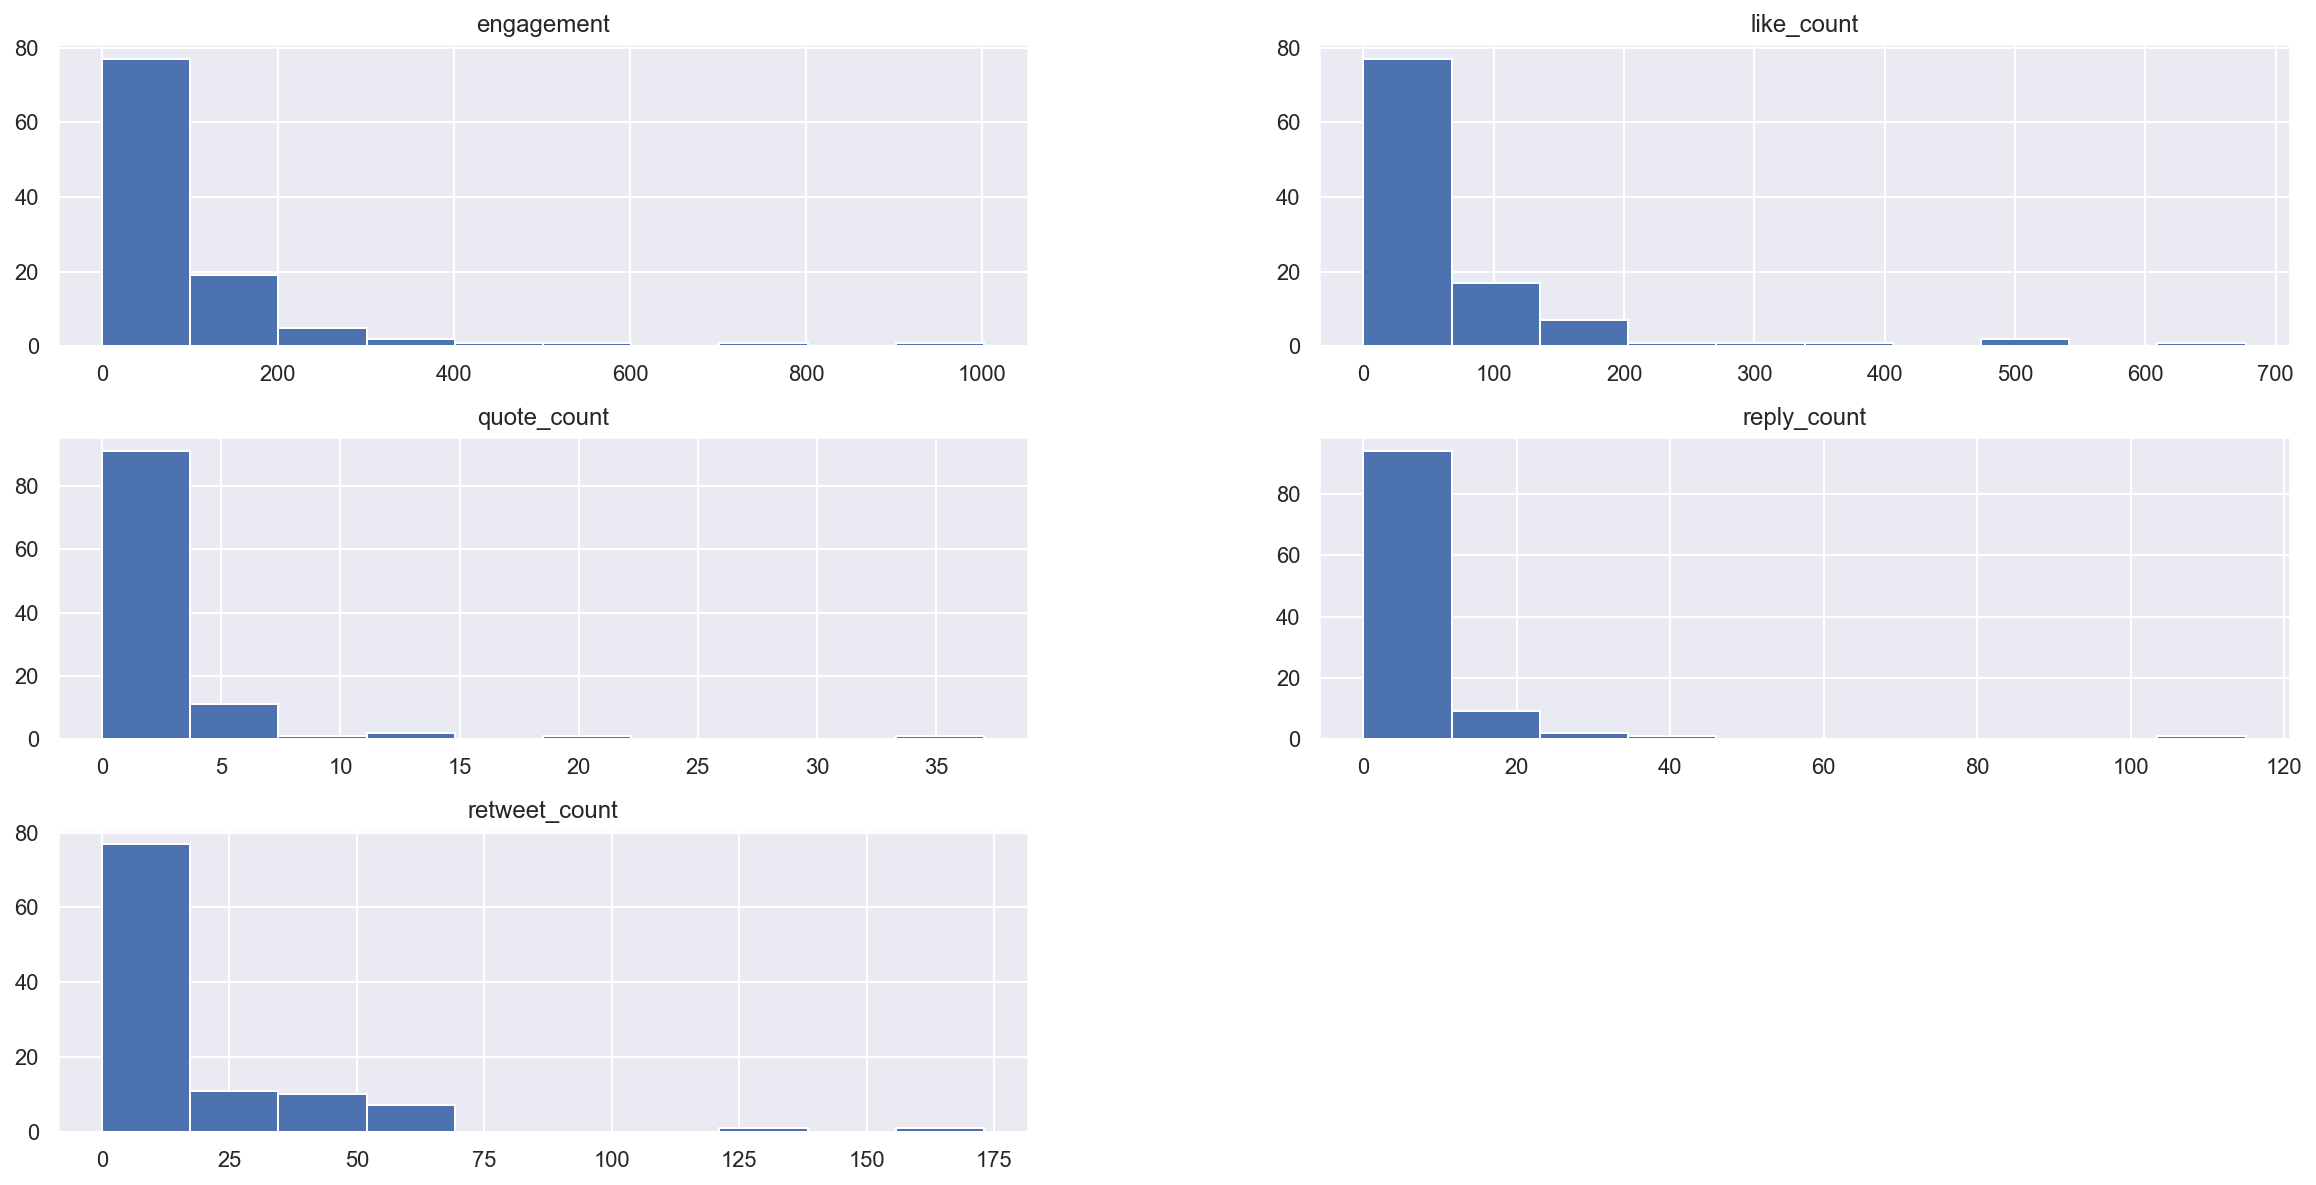

In [14]:
features = ['retweet_count', 'reply_count', 'quote_count', 'like_count', 'engagement']
df[features].hist(figsize=(20, 10))

### Comparing the different Users

In [11]:
usernames = list(df['username'])
usernames_freq = nltk.FreqDist(usernames)
usernames_df = pd.DataFrame({
    'Username': list(usernames_freq.keys()),
    'Count': list(usernames_freq.values())
})

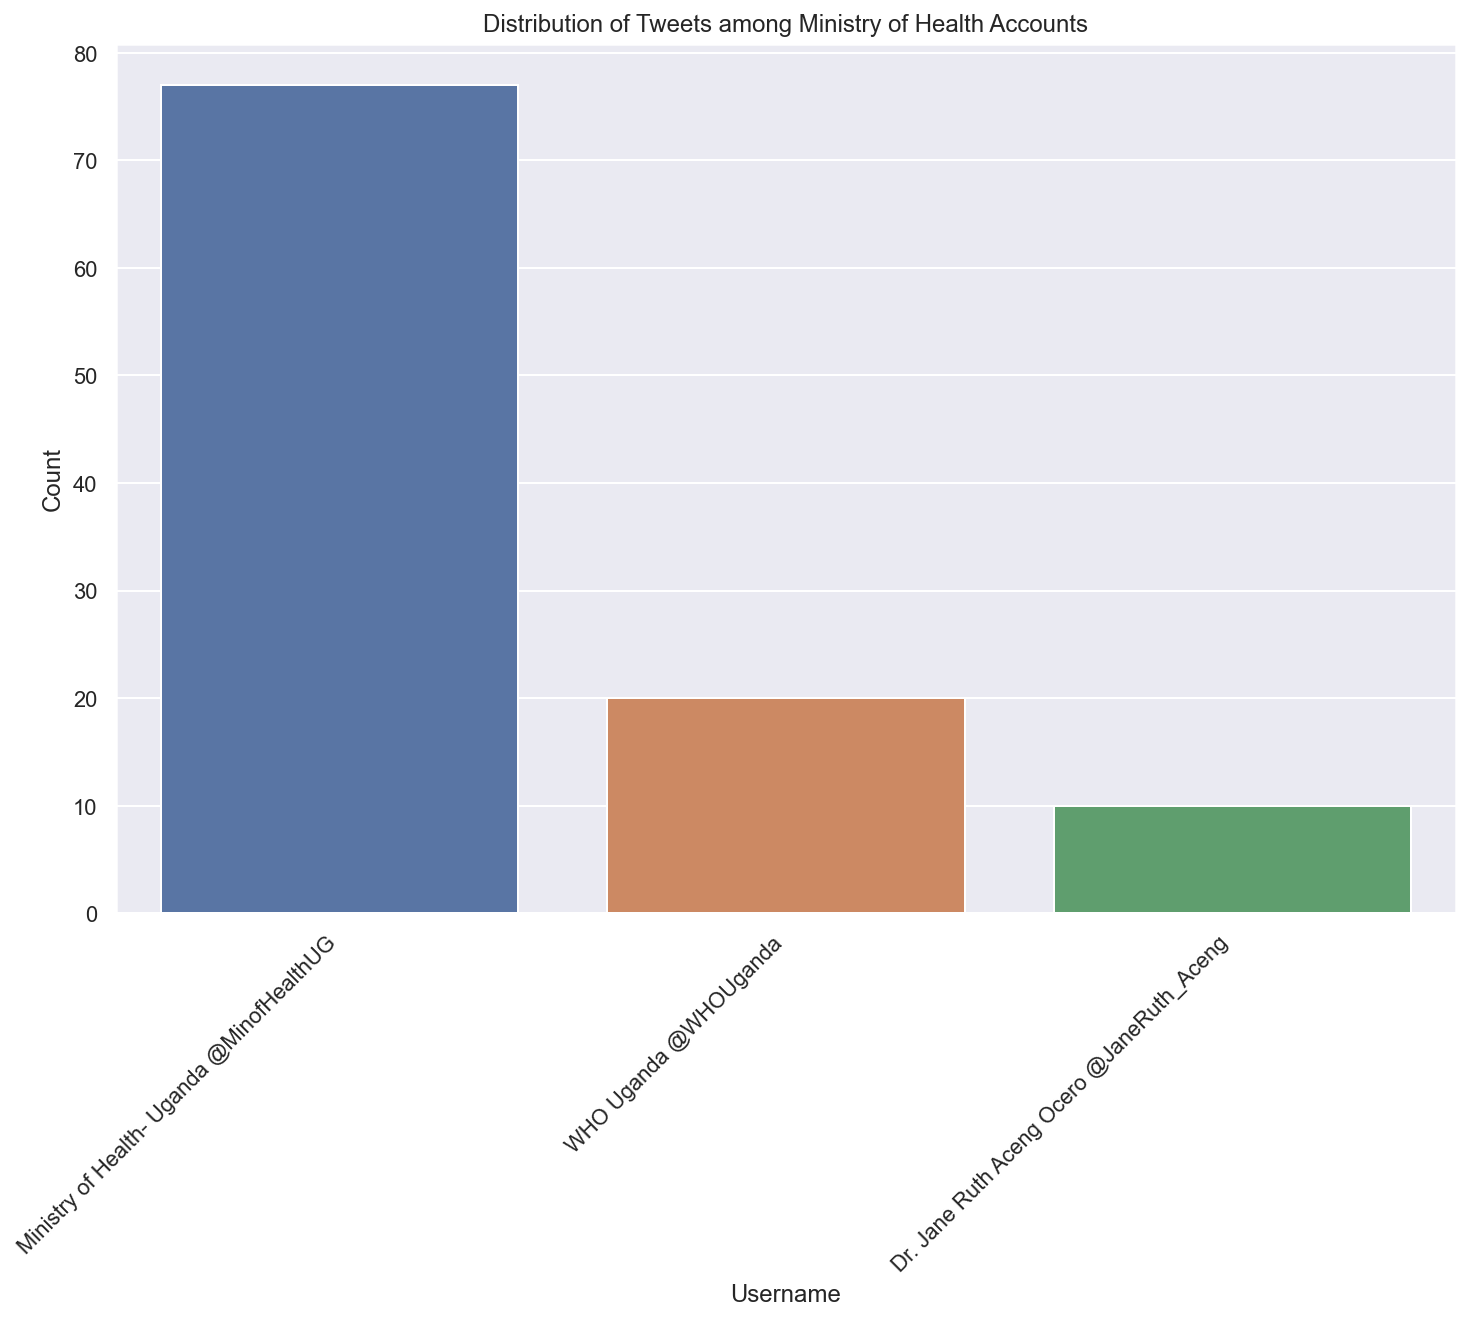

In [12]:
popular_users = usernames_df.nlargest(columns='Count', n=13)
_, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

ax = sns.barplot(x='Username', y='Count', data=popular_users, ax=axes)
ax.set(ylabel="Count")
ax.set_title("Distribution of Tweets among Ministry of Health Accounts")
ax.set_xticklabels(ax.get_xticklabels(),
                  rotation=45,
                  horizontalalignment='right')
plt.show()

#### Engagement received for each user

In [75]:
columns_to_show = ["username", "retweet_count", "reply_count", "quote_count", "like_count", "engagement"]

eng_df = df.groupby(['username'])[columns_to_show]

In [76]:
aggregate = eng_df.agg([np.mean])
average_engagement_df = pd.DataFrame({
    "Username": list(eng_df.groups.keys()),
    "Average Engagement": list(aggregate[('engagement', 'mean')])
})

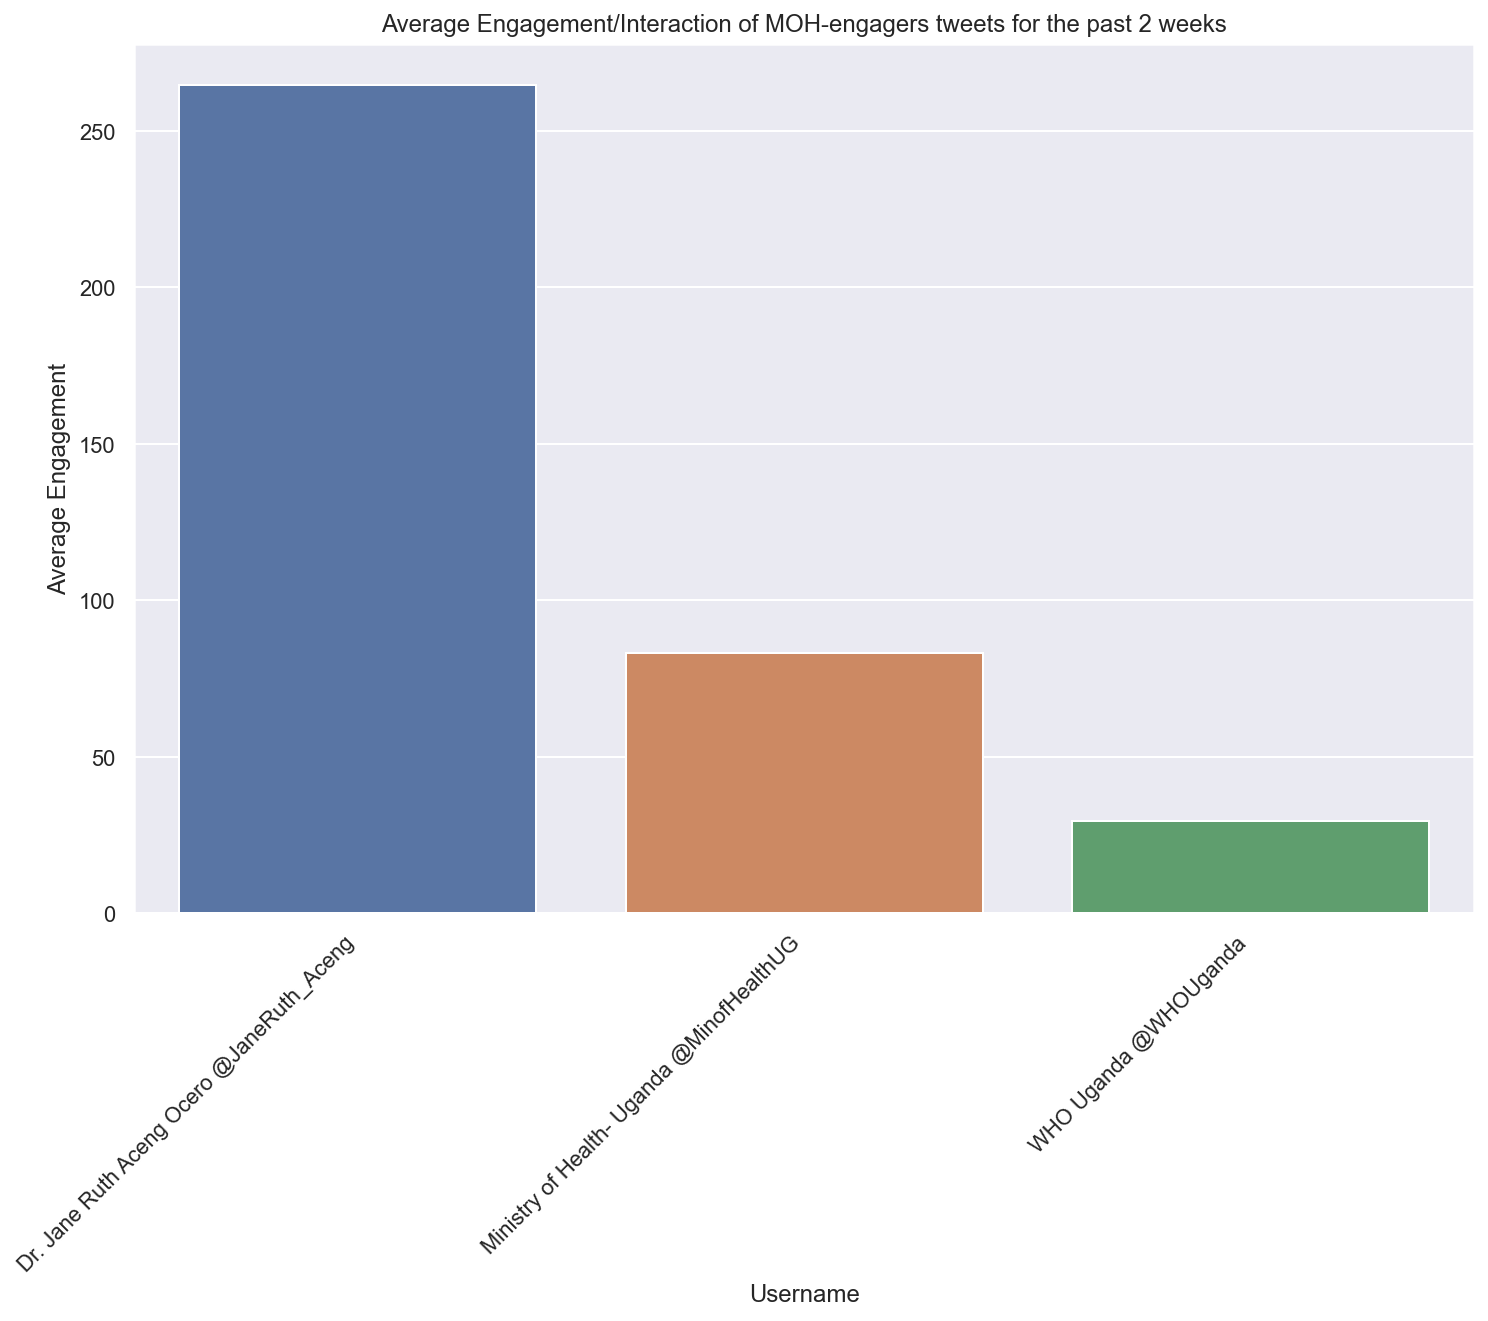

In [77]:
_, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

ax = sns.barplot(x='Username', y="Average Engagement", data=average_engagement_df, ax=axes)
ax.set(ylabel='Average Engagement')
ax.set_title("Average Engagement/Interaction of MOH tweets for the past 2 weeks")
ax.set_xticklabels(ax.get_xticklabels(),
                  rotation=45,
                  horizontalalignment='right')
plt.show()

## Analysis of COVID Tweets

In [90]:
covid_words = ["covid", "covid19", "corona", "coronavirus", "mask", "masks", "lockdown", 
               "staysafe", "virus", "cov", "stayhome", "staysafeug", "socialdistance", 
               "washyourhands", "wearamask", "cases", "covid-19"]
def is_covid_related_tweet(tweet_words):
    for word in covid_words:
        if word in tweet_words:
            return True
    return False

In [91]:
covid_tweets = df[df['words'].apply(lambda t_words: is_covid_related_tweet(t_words))]

In [92]:
covid_tweets.head()

,username,user_id,tweet_id,text,words,retweet_count,reply_count,quote_count,like_count,engagement
created_time,,,,,,,,,,
2020-09-24 09:46:09,Ministry of Health- Uganda @MinofHealthUG,2882328382,1309066585244684291,“Mistrust and disinformation put health and li...,"[mistrust, disinformation, health, lives, risk...",21,5,0,35,61
2020-09-24 11:42:21,Ministry of Health- Uganda @MinofHealthUG,2882328382,1309095824761196545,Results of COVID-19 tests done on 23 September...,"[results, covid-19, tests, done, september, 20...",66,21,2,132,221
2020-09-24 11:43:36,Ministry of Health- Uganda @MinofHealthUG,2882328382,1309096141296996356,The breakdown of the 185 new cases are:\n \nCo...,"[breakdown, cases, contacts, alerts, kampala, ...",17,3,3,31,54
2020-09-24 12:09:09,Ministry of Health- Uganda @MinofHealthUG,2882328382,1309102570170970113,"@Chrishear1 Hi Chris, Masaka has 6 cases.","[chris, masaka, cases]",0,0,0,4,4
2020-09-25 04:47:28,Dr. Jane Ruth Aceng Ocero @JaneRuth_Aceng,4567685369,1309353804316454913,This is incredibly good news for us. Uganda co...,"[incredibly, good, news, uganda, continues, ma...",173,115,37,677,1002


In [93]:
covid_tweets.shape

(45, 10)

### Frequency of covid tweets

In [94]:
daily_covid = covid_tweets['tweet_id'].groupby([covid_tweets.index.date]).count()

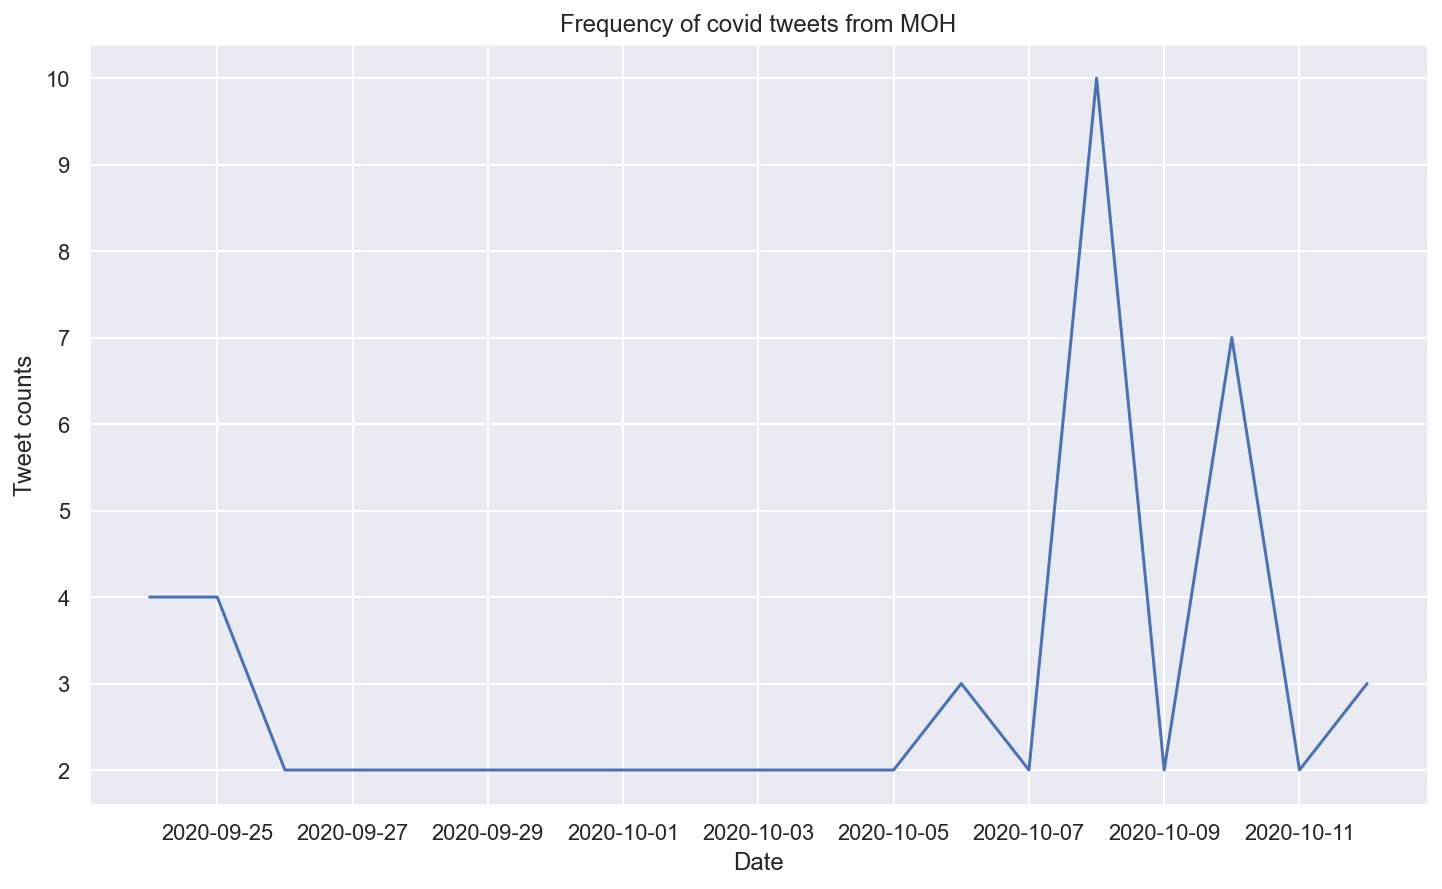

In [96]:
ax = daily_covid.plot(figsize=(12, 7))

ax.set(title="Frequency of covid tweets from MOH")
ax.set(ylabel="Tweet counts")
ax.set(xlabel="Date")

plt.show()

### COVID tweets vs non-COVID tweets

In [103]:
def covid_non_covid(words):
    return "COVID Tweets" if is_covid_related_tweet(words) else "NON-COVID Tweets"
df['Distribution of COVID Tweets'] = df.apply(lambda row: covid_non_covid(row['words']), axis=1)

In [104]:
df.head()

,username,user_id,tweet_id,text,words,retweet_count,reply_count,quote_count,like_count,engagement,IS_COVID,Distribution of COVID Tweets
created_time,,,,,,,,,,,,
2020-09-24 05:08:06,Dr. Jane Ruth Aceng Ocero @JaneRuth_Aceng,4567685369,1308996612082094080,My Prayer for Lira City. “I enthrone you as Go...,"[prayer, lira, city, enthrone, city, dedicate,...",40,37,4,221,302,False,NON-COVID Tweets
2020-09-24 09:46:09,Ministry of Health- Uganda @MinofHealthUG,2882328382,1309066585244684291,“Mistrust and disinformation put health and li...,"[mistrust, disinformation, health, lives, risk...",21,5,0,35,61,True,COVID Tweets
2020-09-24 11:42:21,Ministry of Health- Uganda @MinofHealthUG,2882328382,1309095824761196545,Results of COVID-19 tests done on 23 September...,"[results, covid-19, tests, done, september, 20...",66,21,2,132,221,True,COVID Tweets
2020-09-24 11:43:36,Ministry of Health- Uganda @MinofHealthUG,2882328382,1309096141296996356,The breakdown of the 185 new cases are:\n \nCo...,"[breakdown, cases, contacts, alerts, kampala, ...",17,3,3,31,54,True,COVID Tweets
2020-09-24 11:43:53,Ministry of Health- Uganda @MinofHealthUG,2882328382,1309096213682282497,"Masaka (2), Nwoya (2), Sheema (2), Bushenyi (1...","[masaka, nwoya, sheema, bushenyi, ibanda, isin...",10,2,0,17,29,False,NON-COVID Tweets


<AxesSubplot:xlabel='Distribution of COVID Tweets', ylabel='count'>

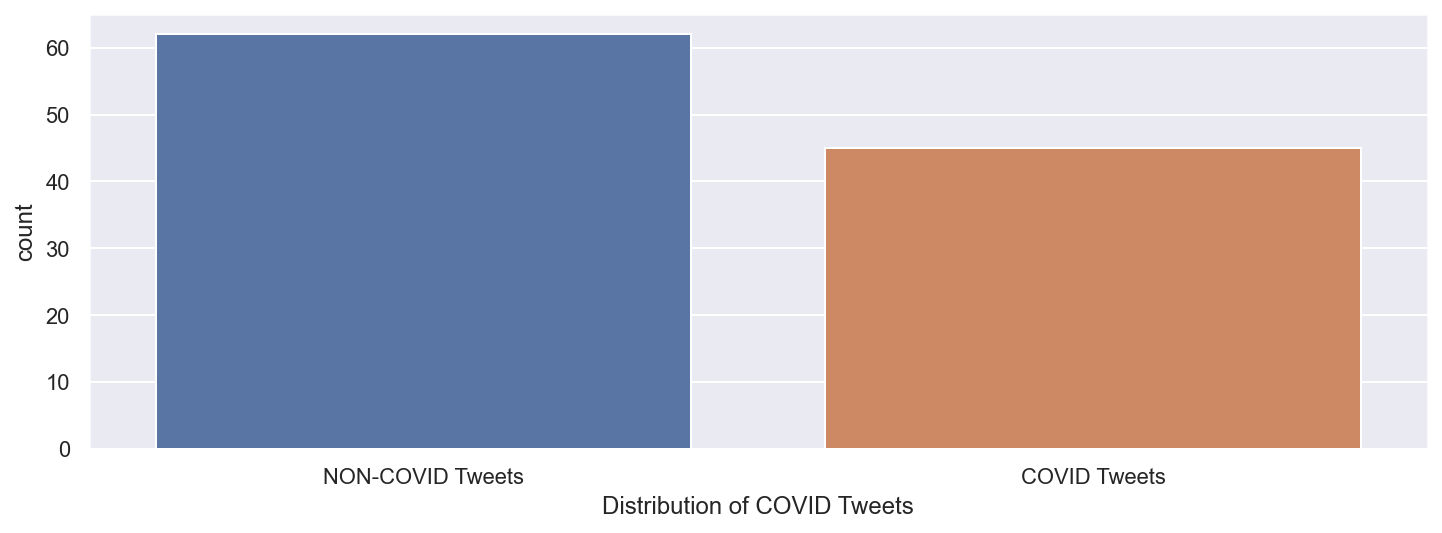

In [105]:
_, axes = plt.subplots(figsize=(12, 4))

sns.countplot(x='Distribution of COVID Tweets', data=df)

### Analyzing the tweets with highest engagement

In [107]:
df.sort_values(by='engagement', ascending=False).head()

,username,user_id,tweet_id,text,words,retweet_count,reply_count,quote_count,like_count,engagement,IS_COVID,Distribution of COVID Tweets
created_time,,,,,,,,,,,,
2020-09-25 04:47:28,Dr. Jane Ruth Aceng Ocero @JaneRuth_Aceng,4567685369,1309353804316454913,This is incredibly good news for us. Uganda co...,"[incredibly, good, news, uganda, continues, ma...",173,115,37,677,1002,True,COVID Tweets
2020-10-10 08:00:19,Ministry of Health- Uganda @MinofHealthUG,2882328382,1314838157423194112,Health workers from Butabika National Referral...,"[health, workers, butabika, national, referral...",136,26,22,537,721,False,NON-COVID Tweets
2020-10-09 05:42:14,Dr. Jane Ruth Aceng Ocero @JaneRuth_Aceng,4567685369,1314441018725588992,Happy Independence Day to all of you. Stay saf...,"[happy, independence, stay, safe, stay, health...",67,25,2,504,598,False,NON-COVID Tweets
2020-10-08 04:00:16,Dr. Jane Ruth Aceng Ocero @JaneRuth_Aceng,4567685369,1314052967381839872,Congratulations to our very own star and new r...,"[congratulations, star, record, holder, 10,000...",30,6,1,394,431,False,NON-COVID Tweets
2020-10-06 14:36:16,Ministry of Health- Uganda @MinofHealthUG,2882328382,1313488250443624449,A team of biomedical engineers from Kyambogo U...,"[team, biomedical, engineers, kyambogo, univer...",67,22,12,276,377,True,COVID Tweets
